# Library yang harus di Install

In [ ]:
# RUN THIS FIRST, CUKUP RUN SEKALI SAJA
!pip install face_recognition

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.1/100.1 MB 6.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for face-recognition-models: filename=face_recognition_models-0.3.0-py2.py3-none-any.whl size=100566170 sha256=dcdff883eaec03bc3e97499755e028726029d92409b641dbf784153f29e1a7ef
  Stored in directory: /root/.cache/pip/wheels/7a/eb/cf/e9eced74122b679557f597bb7c8e4c739cfcac526db1fd523d
Successfully built face-recognition-models


setelah pip install..

**Buat folder baru di files, berjudul 'fotoPeserta'**

**Isi folder dengan wajah-wajah mahasiswa dengan file mencantumkan nama mahasiswanya.**

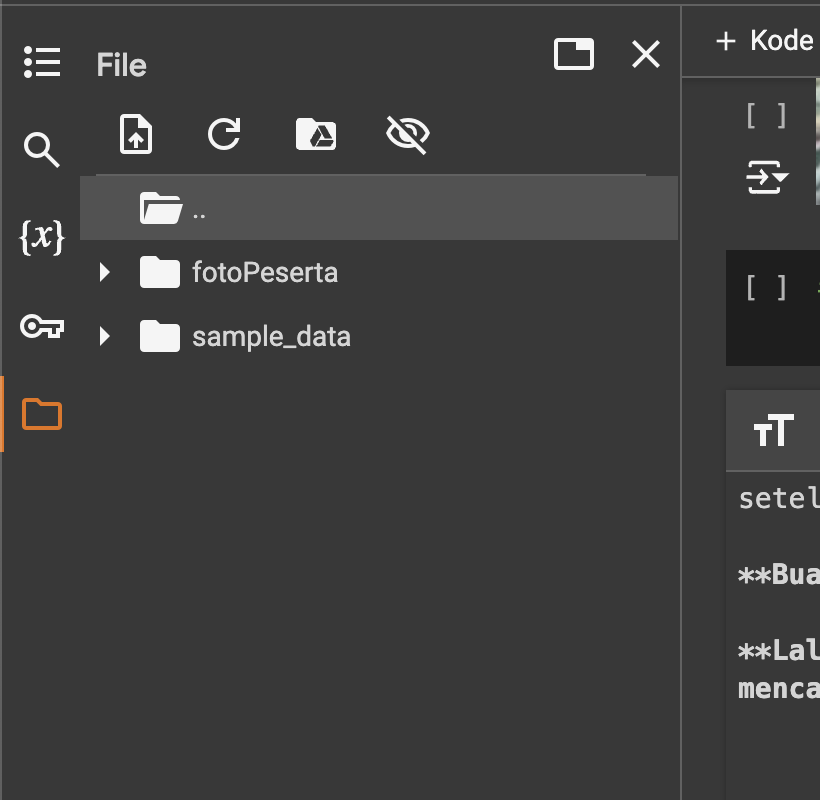

# Main Function Dan Penggunaan Secara Langsung

INI ADALAH BASE DARI FACE RECOGNITION

HANYA MURNI SEBUAH FUNGSI FACE RECOGNITION

(Boleh di run untuk coba fitur face recognitionnya)

<IPython.core.display.Javascript object>

Saved to photo.jpg


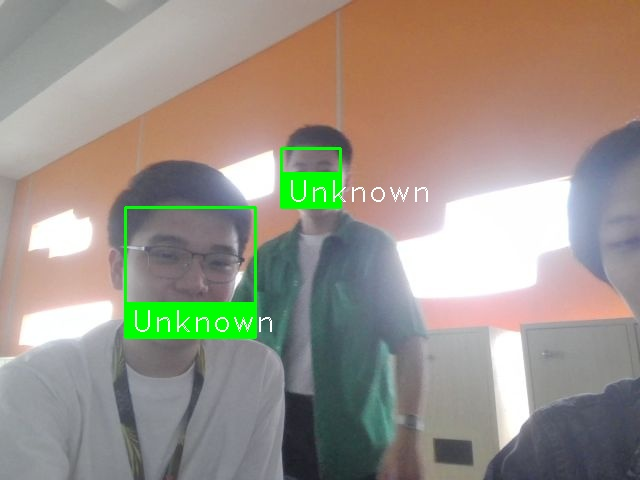

In [ ]:
# Import necessary libraries

from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import os
import face_recognition

# Function to convert JavaScript object (image) to OpenCV BGR image
def js_to_image(js_reply):
    """
    Params:
        js_reply: JavaScript object containing image from webcam
    Returns:
        img: OpenCV BGR image
    """
    image_bytes = b64decode(js_reply.split(',')[1])  # Decode base64 image
    jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)  # Convert bytes to numpy array
    img = cv2.imdecode(jpg_as_np, flags=1)  # Decode numpy array to OpenCV BGR image
    return img

# Function to convert OpenCV Rectangle bounding box image to base64 byte string for overlay
def bbox_to_bytes(bbox_array):
    """
    Params:
        bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream
    Returns:
        bytes: Base64 image byte string
    """
    bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')  # Convert array to PIL image
    iobuf = io.BytesIO()
    bbox_PIL.save(iobuf, format='png')  # Format bbox to png
    bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))
    return bbox_bytes

# Initialize Haar Cascade face detection model
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# Function to encode known faces from the database
def encode_faces(fotoPeserta_folder):
    known_face_encodings = []
    known_face_names = []
    for file_name in os.listdir(fotoPeserta_folder):
        if file_name.endswith(('.jpg', '.png')):
            image_path = os.path.join(fotoPeserta_folder, file_name)
            image = face_recognition.load_image_file(image_path)
            face_encodings = face_recognition.face_encodings(image)
            if face_encodings:
                known_face_encodings.append(face_encodings[0])
                known_face_names.append(os.path.splitext(file_name)[0])
    return known_face_encodings, known_face_names

# Function to capture image from webcam, detect faces, recognize faces, and save image with bounding boxes and labels
def take_photo(filename='photo.jpg', quality=0.8, known_face_encodings=[], known_face_names=[]):
    js = Javascript('''
        async function takePhoto(quality) {
            const div = document.createElement('div');
            const capture = document.createElement('button');
            capture.textContent = 'Capture';
            div.appendChild(capture);

            const video = document.createElement('video');
            video.style.display = 'block';
            const stream = await navigator.mediaDevices.getUserMedia({video: true});

            document.body.appendChild(div);
            div.appendChild(video);
            video.srcObject = stream;
            await video.play();

            // Resize the output to fit the video element.
            google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

            // Wait for Capture to be clicked.
            await new Promise((resolve) => capture.onclick = resolve);

            const canvas = document.createElement('canvas');
            canvas.width = video.videoWidth;
            canvas.height = video.videoHeight;
            canvas.getContext('2d').drawImage(video, 0, 0);
            stream.getVideoTracks()[0].stop();
            div.remove();
            return canvas.toDataURL('image/jpeg', quality);
        }
    ''')
    display(js)

    # Get photo data
    data = eval_js('takePhoto({})'.format(quality))
    # Get OpenCV format image
    img = js_to_image(data)
    # Grayscale img for face detection
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Get face bounding box coordinates using Haar Cascade
    faces = face_cascade.detectMultiScale(gray)

    # Process each detected face
    face_locations = []
    for (x, y, w, h) in faces:
        face_locations.append((y, x+w, y+h, x))  # Adjust from OpenCV to dlib format
        img = cv2.rectangle(img, (x, y), (x+w, y+h), (255, 0, 0), 2)

    # Convert the image to RGB (required for face_recognition)
    rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Encode the faces detected in the captured image
    unknown_face_encodings = face_recognition.face_encodings(rgb_img, face_locations)

    face_names = []
    for face_encoding in unknown_face_encodings:
        if known_face_encodings:
            matches = face_recognition.compare_faces(known_face_encodings, face_encoding)
            name = "Unknown"

            # Use the known face with the smallest distance to the new face
            face_distances = face_recognition.face_distance(known_face_encodings, face_encoding)
            best_match_index = np.argmin(face_distances)
            if matches[best_match_index]:
                name = known_face_names[best_match_index]

            face_names.append(name)
        else:
            face_names.append("No database provided")

    # Draw labels on the image
    for (top, right, bottom, left), name in zip(face_locations, face_names):
        cv2.rectangle(img, (left, top), (right, bottom), (0, 255, 0), 2)
        cv2.rectangle(img, (left, bottom - 35), (right, bottom), (0, 255, 0), cv2.FILLED)
        font = cv2.FONT_HERSHEY_DUPLEX
        cv2.putText(img, name, (left + 6, bottom - 6), font, 1.0, (255, 255, 255), 1)

    # Save the image
    cv2.imwrite(filename, img)

    return filename


# Load known faces
fotoPeserta_folder = 'fotoPeserta'  # Path to your folder containing face images
known_face_encodings, known_face_names = encode_faces(fotoPeserta_folder)

try:
    filename = take_photo('photo.jpg', known_face_encodings=known_face_encodings, known_face_names=known_face_names)
    print('Saved to {}'.format(filename))

    # Show the image which was just taken
    display(Image(filename))
except Exception as err:
    # Errors will be thrown if the user does not have a webcam or if they do not
    # grant the page permission to access it
    print(str(err))


FUNGSIONALITAS FULL UNTUK KEHADIRAN MAHASISWA

PASTIKAN UPLOAD DULU FILE WAJAH MAHASISWA KE 'fotoPeserta'

In [ ]:
# Import necessary libraries

from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import os
import face_recognition
from datetime import datetime

# Function to convert JavaScript object (image) to OpenCV BGR image
def js_to_image(js_reply):
    image_bytes = b64decode(js_reply.split(',')[1])
    jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
    img = cv2.imdecode(jpg_as_np, flags=1)
    return img

# Function to convert OpenCV Rectangle bounding box image to base64 byte string for overlay
def bbox_to_bytes(bbox_array):
    bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
    iobuf = io.BytesIO()
    bbox_PIL.save(iobuf, format='png')
    bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))
    return bbox_bytes

# Initialize Haar Cascade face detection model
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# Function to encode known faces from the database
def encode_faces(fotoPeserta_folder):
    known_face_encodings = []
    known_face_names = []
    for file_name in os.listdir(fotoPeserta_folder):
        if file_name.endswith(('.jpg', '.png')):
            image_path = os.path.join(fotoPeserta_folder, file_name)
            image = face_recognition.load_image_file(image_path)
            face_encodings = face_recognition.face_encodings(image)
            if face_encodings:
                known_face_encodings.append(face_encodings[0])
                known_face_names.append(os.path.splitext(file_name)[0])
    return known_face_encodings, known_face_names

# Function to capture image from webcam, detect faces, recognize faces, and return recognized names
def recognize_faces(known_face_encodings=[], known_face_names=[]):
    js = Javascript('''
        async function takePhoto(quality) {
            const div = document.createElement('div');
            const capture = document.createElement('button');
            capture.textContent = 'Capture';
            div.appendChild(capture);

            const video = document.createElement('video');
            video.style.display = 'block';
            const stream = await navigator.mediaDevices.getUserMedia({video: true});

            document.body.appendChild(div);
            div.appendChild(video);
            video.srcObject = stream;
            await video.play();

            // Resize the output to fit the video element.
            google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

            // Wait for Capture to be clicked.
            await new Promise((resolve) => capture.onclick = resolve);

            const canvas = document.createElement('canvas');
            canvas.width = video.videoWidth;
            canvas.height = video.videoHeight;
            canvas.getContext('2d').drawImage(video, 0, 0);
            stream.getVideoTracks()[0].stop();
            div.remove();
            return canvas.toDataURL('image/jpeg', quality);
        }
    ''')
    display(js)

    # Get photo data
    data = eval_js('takePhoto(0.8)')
    # Get OpenCV format image
    img = js_to_image(data)
    # Grayscale img for face detection
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Get face bounding box coordinates using Haar Cascade
    faces = face_cascade.detectMultiScale(gray)

    # Process each detected face
    face_locations = []
    for (x, y, w, h) in faces:
        face_locations.append((y, x+w, y+h, x))
        img = cv2.rectangle(img, (x, y), (x+w, y+h), (255, 0, 0), 2)

    # Convert the image to RGB (required for face_recognition)
    rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Encode the faces detected in the captured image
    unknown_face_encodings = face_recognition.face_encodings(rgb_img, face_locations)

    face_names = []
    for face_encoding in unknown_face_encodings:
        if known_face_encodings:
            matches = face_recognition.compare_faces(known_face_encodings, face_encoding)
            name = "Unknown"

            # Use the known face with the smallest distance to the new face
            face_distances = face_recognition.face_distance(known_face_encodings, face_encoding)
            best_match_index = np.argmin(face_distances)
            if matches[best_match_index]:
                name = known_face_names[best_match_index]

            face_names.append(name)
        else:
            face_names.append("No database provided")

    # Save the image with rectangles drawn
    cv2.imwrite('captured_photo.jpg', img)

    return face_names

# Load known faces
fotoPeserta_folder = 'fotoPeserta'
known_face_encodings, known_face_names = encode_faces(fotoPeserta_folder)

# Initialize attendance dictionary
attendance = {}

# Entrance stamp
print("Please look at the camera for entrance stamp...")
entrance_names = recognize_faces(known_face_encodings, known_face_names)
for name in entrance_names:
    if name != "Unknown" and name != "No database provided":
        attendance[name] = {"entrance": datetime.now().strftime("%Y-%m-%d %H:%M:%S")}
print("Entrance recorded for:", entrance_names)

# Wait for the user to exit (this is a placeholder, in a real system you would have a proper exit flow)
input("Press Enter to record exit stamp...")

# Exit stamp
print("Please look at the camera for exit stamp...")
exit_names = recognize_faces(known_face_encodings, known_face_names)
for name in exit_names:
    if name in attendance:
        attendance[name]["exit"] = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
print("Exit recorded for:", exit_names)

# Display the attendance records
print("\nAttendance Records:")
for name, times in attendance.items():
    print(f"{name}: Entered at {times['entrance']}, Exited at {times.get('exit', 'Not yet exited')}")


Please look at the camera for entrance stamp...


<IPython.core.display.Javascript object>

Entrance recorded for: ['Bryan Eugene']
Press Enter to record exit stamp...
Please look at the camera for exit stamp...


<IPython.core.display.Javascript object>

Exit recorded for: ['Bryan Eugene', 'Bryan Eugene']

Attendance Records:
Bryan Eugene: Entered at 2024-06-10 04:19:08, Exited at 2024-06-10 04:19:14


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def evaluate_accuracy(test_images_folder, known_face_encodings, known_face_names):
    y_true = []
    y_pred = []

    for file_name in os.listdir(test_images_folder):
        if file_name.endswith(('.jpg', '.png')):
            image_path = os.path.join(test_images_folder, file_name)
            image = face_recognition.load_image_file(image_path)
            face_encodings = face_recognition.face_encodings(image)

            if face_encodings:
                true_name = os.path.splitext(file_name)[0]
                y_true.append(true_name)

                matches = face_recognition.compare_faces(known_face_encodings, face_encodings[0])
                face_distances = face_recognition.face_distance(known_face_encodings, face_encodings[0])
                best_match_index = np.argmin(face_distances)

                if matches[best_match_index]:
                    predicted_name = known_face_names[best_match_index]
                else:
                    predicted_name = "Unknown"

                y_pred.append(predicted_name)

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')

    return accuracy, precision, recall, f1

# Misalkan kita memiliki folder 'test_images' untuk testing set
test_images_folder = 'fotoPeserta'
accuracy, precision, recall, f1 = evaluate_accuracy(test_images_folder, known_face_encodings, known_face_names)

print(f'Accuracy: {accuracy * 100}%')
print(f'Precision: {precision * 100}%')
print(f'Recall: {recall * 100}%')
print(f'F1 Score: {f1 * 100}%')


Accuracy: 100.0%
Precision: 100.0%
Recall: 100.0%
F1 Score: 100.0%


- Kita Test Dengan Menggunakan beberapa dataset untuk mengetahui apakah metode ini bisa di pakai dengan baik

In [ ]:
!unzip lfw-deepfunneled\(2\).zip

Archive:  lfw-deepfunneled(2).zip
replace lfw-deepfunneled/Aaron_Eckhart/Aaron_Eckhart_0001.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
# Import necessary libraries
import cv2
import numpy as np
import os
import face_recognition
import pandas as pd
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split

# Initialize Haar Cascade face detection model
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# Function to encode known faces from a given dataset
def encode_faces(dataset_folder):
    known_face_encodings = []
    known_face_names = []
    for person_name in os.listdir(dataset_folder):
        person_folder = os.path.join(dataset_folder, person_name)
        if os.path.isdir(person_folder):
            for image_name in os.listdir(person_folder):
                image_path = os.path.join(person_folder, image_name)
                image = face_recognition.load_image_file(image_path)
                face_encodings = face_recognition.face_encodings(image)
                if face_encodings:
                    known_face_encodings.append(face_encodings[0])
                    known_face_names.append(person_name)
                else:
                    print(f"No face found in image: {image_path}")
    return known_face_encodings, known_face_names

# Function to evaluate the model using test data
def evaluate_model(test_encodings, test_names, known_encodings, known_names):
    y_true = []
    y_pred = []

    for face_encoding, true_name in zip(test_encodings, test_names):
        matches = face_recognition.compare_faces(known_encodings, face_encoding)
        name = "Unknown"
        face_distances = face_recognition.face_distance(known_encodings, face_encoding)
        best_match_index = np.argmin(face_distances)
        if matches[best_match_index]:
            name = known_names[best_match_index]
        y_true.append(true_name)
        y_pred.append(name)

    # Print the classification report
    print(classification_report(y_true, y_pred))

    # Calculate and print the accuracy
    accuracy = accuracy_score(y_true, y_pred)
    print(f"Accuracy: {accuracy:.2f}")

# Load known faces from the LFW dataset
lfw_folder = 'lfw-deepfunneled'  # Update with the correct path to your LFW folder
known_face_encodings, known_face_names = encode_faces(lfw_folder)

if len(known_face_encodings) == 0:
    print("No face encodings found. Please check your dataset path and images.")
else:
    # Evaluate the model on the entire dataset
    evaluate_model(known_face_encodings, known_face_names, known_face_encodings, known_face_names)

No face found in image: lfw-deepfunneled/Chung_Mong-hun/Chung_Mong-hun_0001.jpg
No face found in image: lfw-deepfunneled/Arlen_Specter/Arlen_Specter_0003.jpg
No face found in image: lfw-deepfunneled/Dawn_Staley/Dawn_Staley_0001.jpg
No face found in image: lfw-deepfunneled/Brian_Florence/Brian_Florence_0001.jpg
No face found in image: lfw-deepfunneled/Brawley_King/Brawley_King_0001.jpg
No face found in image: lfw-deepfunneled/Billy_Andrade/Billy_Andrade_0001.jpg
No face found in image: lfw-deepfunneled/Charles_Mathews/Charles_Mathews_0002.jpg
No face found in image: lfw-deepfunneled/Chan_Gailey/Chan_Gailey_0002.jpg
No face found in image: lfw-deepfunneled/Abdoulaye_Wade/Abdoulaye_Wade_0003.jpg
No face found in image: lfw-deepfunneled/Derrick_Rodgers/Derrick_Rodgers_0001.jpg
No face found in image: lfw-deepfunneled/Andy_Roddick/Andy_Roddick_0005.jpg
                              precision    recall  f1-score   support

               Aaron_Eckhart       1.00      1.00      1.00         1

Setelah kita test ternyata hasilnya cukup baik namun, tampaknya akan mengalami overfitting

# Code Yang sudah di Modifikasi untuk multiple faces / beberapa orang dalam sekali capturing gambar recognition. Untuk pengoprasian dan metode masih sama dengan sebelumnya.

In [ ]:
# Import necessary libraries
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import os
import face_recognition
from datetime import datetime

# Function to convert JavaScript object (image) to OpenCV BGR image
def js_to_image(js_reply):
    image_bytes = b64decode(js_reply.split(',')[1])
    jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
    img = cv2.imdecode(jpg_as_np, flags=1)
    return img

# Function to convert OpenCV Rectangle bounding box image to base64 byte string for overlay
def bbox_to_bytes(bbox_array):
    bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
    iobuf = io.BytesIO()
    bbox_PIL.save(iobuf, format='png')
    bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))
    return bbox_bytes

# Initialize Haar Cascade face detection model
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# Function to encode known faces from the database
def encode_faces(fotoPeserta_folder):
    known_face_encodings = []
    known_face_names = []
    for file_name in os.listdir(fotoPeserta_folder):
        if file_name.endswith(('.jpg', '.png')):
            image_path = os.path.join(fotoPeserta_folder, file_name)
            image = face_recognition.load_image_file(image_path)
            face_encodings = face_recognition.face_encodings(image)
            if face_encodings:
                known_face_encodings.append(face_encodings[0])
                known_face_names.append(os.path.splitext(file_name)[0])
    return known_face_encodings, known_face_names

# Function to capture image from webcam, detect faces, recognize faces, and return recognized names
def recognize_faces(known_face_encodings=[], known_face_names=[]):
    js = Javascript('''
        async function takePhoto(quality) {
            const div = document.createElement('div');
            const capture = document.createElement('button');
            capture.textContent = 'Capture';
            div.appendChild(capture);

            const video = document.createElement('video');
            video.style.display = 'block';
            const stream = await navigator.mediaDevices.getUserMedia({video: true});

            document.body.appendChild(div);
            div.appendChild(video);
            video.srcObject = stream;
            await video.play();

            // Resize the output to fit the video element.
            google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

            // Wait for Capture to be clicked.
            await new Promise((resolve) => capture.onclick = resolve);

            const canvas = document.createElement('canvas');
            canvas.width = video.videoWidth;
            canvas.height = video.videoHeight;
            canvas.getContext('2d').drawImage(video, 0, 0);
            stream.getVideoTracks()[0].stop();
            div.remove();
            return canvas.toDataURL('image/jpeg', quality);
        }
    ''')
    display(js)

    # Get photo data
    data = eval_js('takePhoto(0.8)')
    # Get OpenCV format image
    img = js_to_image(data)
    # Grayscale img for face detection
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Get face bounding box coordinates using Haar Cascade
    faces = face_cascade.detectMultiScale(gray)

    # Process each detected face
    face_locations = []
    for (x, y, w, h) in faces:
        face_locations.append((y, x+w, y+h, x))
        img = cv2.rectangle(img, (x, y), (x+w, y+h), (255, 0, 0), 2)

    # Convert the image to RGB (required for face_recognition)
    rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Encode the faces detected in the captured image
    unknown_face_encodings = face_recognition.face_encodings(rgb_img, face_locations)

    face_names = []
    for face_encoding in unknown_face_encodings:
        if known_face_encodings:
            matches = face_recognition.compare_faces(known_face_encodings, face_encoding)
            name = "Unknown"

            # Use the known face with the smallest distance to the new face
            face_distances = face_recognition.face_distance(known_face_encodings, face_encoding)
            best_match_index = np.argmin(face_distances)
            if matches[best_match_index]:
                name = known_face_names[best_match_index]

            face_names.append(name)
        else:
            face_names.append("No database provided")

    # Save the image with rectangles drawn
    cv2.imwrite('captured_photo.jpg', img)

    return face_names

# Load known faces
fotoPeserta_folder = 'fotoPeserta'
known_face_encodings, known_face_names = encode_faces(fotoPeserta_folder)

# Initialize attendance dictionary
attendance = {}

# Entrance stamp
print("Please look at the camera for entrance stamp...")
entrance_names = recognize_faces(known_face_encodings, known_face_names)
for name in entrance_names:
    if name != "Unknown" and name != "No database provided":
        attendance[name] = {"entrance": datetime.now().strftime("%Y-%m-%d %H:%M:%S")}
print("Entrance recorded for:", entrance_names[:10])  # Print only the first 10 names

# Wait for the user to exit (this is a placeholder, in a real system you would have a proper exit flow)
input("Press Enter to record exit stamp...")

# Exit stamp
print("Please look at the camera for exit stamp...")
exit_names = recognize_faces(known_face_encodings, known_face_names)
for name in exit_names:
    if name in attendance:
        attendance[name]["exit"] = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
print("Exit recorded for:", exit_names[:10])  # Print only the first 10 names

# Display the attendance records
print("\nAttendance Records:")
for name, times in attendance.items():
    print(f"{name}: Entered at {times['entrance']}, Exited at {times.get('exit', 'Not yet exited')}")

# Ini kode untuk pengambilan Gambar Secara Berkala Dengan Interval 30 menit sehingga membuat program mengcapture gambar setiap 30 menit untuk Attendance

- Saya Juga Sudah mencoba mengubah resolusi yang di ambil menjadi lebih bagus dengan mengubah scale dan size dari gambar yang di ambil sehingga dengan jarak yang jauh sekalipun dapat mengambil gambar dengan jelas

- Ini Code hasil akhir yang sudah di modifikasi

In [ ]:
# Import necessary libraries
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import os
import face_recognition
from datetime import datetime, timedelta
import time

# Function to convert JavaScript object (image) to OpenCV BGR image
def js_to_image(js_reply):
    image_bytes = b64decode(js_reply.split(',')[1])
    jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
    img = cv2.imdecode(jpg_as_np, flags=1)
    return img

# Function to convert OpenCV Rectangle bounding box image to base64 byte string for overlay
def bbox_to_bytes(bbox_array):
    bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
    iobuf = io.BytesIO()
    bbox_PIL.save(iobuf, format='png')
    bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))
    return bbox_bytes

# Initialize Haar Cascade face detection model
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# Function to encode known faces from the database
def encode_faces(fotoPeserta_folder):
    known_face_encodings = []
    known_face_names = []
    for file_name in os.listdir(fotoPeserta_folder):
        if file_name.endswith(('.jpg', '.png')):
            image_path = os.path.join(fotoPeserta_folder, file_name)
            image = face_recognition.load_image_file(image_path)
            face_encodings = face_recognition.face_encodings(image)
            if face_encodings:
                known_face_encodings.append(face_encodings[0])
                known_face_names.append(os.path.splitext(file_name)[0])
    return known_face_encodings, known_face_names

# Function to capture image from webcam, detect faces, recognize faces, and return recognized names
def recognize_faces(known_face_encodings=[], known_face_names=[]):
    js = Javascript('''
        async function takePhoto(quality) {
            const div = document.createElement('div');
            const capture = document.createElement('button');
            capture.textContent = 'Capture';
            div.appendChild(capture);

            const video = document.createElement('video');
            video.style.display = 'block';
            const stream = await navigator.mediaDevices.getUserMedia({video: true});

            const qualitySelect = document.createElement('select');
            const lowOption = document.createElement('option');
            lowOption.value = 0.5;
            lowOption.text = 'Low';
            const mediumOption = document.createElement('option');
            mediumOption.value = 0.8;
            mediumOption.text = 'Medium';
            const highOption = document.createElement('option');
            highOption.value = 1.0;
            highOption.text = 'High';
            qualitySelect.appendChild(lowOption);
            qualitySelect.appendChild(mediumOption);
            qualitySelect.appendChild(highOption);
            div.appendChild(qualitySelect);

            document.body.appendChild(div);
            div.appendChild(video);
            video.srcObject = stream;
            await video.play();

            // Resize the output to fit the video element.
            google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

            // Wait for Capture to be clicked.
            await new Promise((resolve) => capture.onclick = resolve);

            const selectedQuality = qualitySelect.value;
            const canvas = document.createElement('canvas');
            canvas.width = video.videoWidth;
            canvas.height = video.videoHeight;
            canvas.getContext('2d').drawImage(video, 0, 0);
            stream.getVideoTracks()[0].stop();
            div.remove();
            return canvas.toDataURL('image/jpeg', selectedQuality);
        }
    ''')
    display(js)

    # Get photo data
    data = eval_js('takePhoto(0.8)')
    # Get OpenCV format image
    img = js_to_image(data)
    # Grayscale img for face detection
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Get face bounding box coordinates using Haar Cascade
    faces = face_cascade.detectMultiScale(gray)

    # Process each detected face
    face_locations = []
    for (x, y, w, h) in faces:
        face_locations.append((y, x+w, y+h, x))
        img = cv2.rectangle(img, (x, y), (x+w, y+h), (255, 0, 0), 2)

    # Convert the image to RGB (required for face_recognition)
    rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Encode the faces detected in the captured image
    unknown_face_encodings = face_recognition.face_encodings(rgb_img, face_locations)

    face_names = []
    for face_encoding in unknown_face_encodings:
        if known_face_encodings:
            matches = face_recognition.compare_faces(known_face_encodings, face_encoding)
            name = "Unknown"

            # Use the known face with the smallest distance to the new face
            face_distances = face_recognition.face_distance(known_face_encodings, face_encoding)
            best_match_index = np.argmin(face_distances)
            if matches[best_match_index]:
                name = known_face_names[best_match_index]

            face_names.append(name)
        else:
            face_names.append("No database provided")

    # Save the image with rectangles drawn
    cv2.imwrite('captured_photo.jpg', img)

    return face_names

# Load known faces
fotoPeserta_folder = 'fotoPeserta'
known_face_encodings, known_face_names = encode_faces(fotoPeserta_folder)

# Initialize attendance dictionary
attendance = {}

# Function to record attendance every 30 minutes for 120 minutes
def record_attendance(duration_minutes=120):
    start_time = datetime.now()
    end_time = start_time + timedelta(minutes=duration_minutes)
    while datetime.now() < end_time:
        print("Please look at the camera for attendance...")
        recognized_names = recognize_faces(known_face_encodings, known_face_names)
        current_time = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
        for name in recognized_names:
            if name != "Unknown" and name != "No database provided":
                if name not in attendance:
                    attendance[name] = []
                attendance[name].append(current_time)
        print("Attendance recorded for:", recognized_names)
        time.sleep(1800)  # Sleep for 30 minutes (1800 seconds)

# Start recording attendance
record_attendance()

- Code ini hanya tambahan yang dimana program tidak mengharuskan user untuk menekan tombol capture lagi. Jadi setelah pemakaian pertama program akan mengcapture dengan sendirinya.

In [ ]:
# Function to capture image from webcam, detect faces, recognize faces, and return recognized names
def recognize_faces(known_face_encodings=[], known_face_names=[], quality=0.8):
    js = Javascript(f'''
        async function takePhoto() {{
            const video = document.createElement('video');
            const stream = await navigator.mediaDevices.getUserMedia({{video: true}});
            video.srcObject = stream;
            await new Promise((resolve) => video.onloadedmetadata = resolve);

            // Take a snapshot
            const canvas = document.createElement('canvas');
            canvas.width = video.videoWidth;
            canvas.height = video.videoHeight;
            canvas.getContext('2d').drawImage(video, 0, 0, canvas.width, canvas.height);
            stream.getVideoTracks()[0].stop();

            return canvas.toDataURL('image/jpeg', {quality});
        }}
    ''')
    display(js)

    # Get photo data
    data = eval_js('takePhoto()')
    # Get OpenCV format image
    img = js_to_image(data)
    # Grayscale img for face detection
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Get face bounding box coordinates using Haar Cascade
    faces = face_cascade.detectMultiScale(gray)

    # Process each detected face
    face_locations = []
    for (x, y, w, h) in faces:
        face_locations.append((y, x+w, y+h, x))
        img = cv2.rectangle(img, (x, y), (x+w, y+h), (255, 0, 0), 2)

    # Convert the image to RGB (required for face_recognition)
    rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Encode the faces detected in the captured image
    unknown_face_encodings = face_recognition.face_encodings(rgb_img, face_locations)

    face_names = []
    for face_encoding in unknown_face_encodings:
        if known_face_encodings:
            matches = face_recognition.compare_faces(known_face_encodings, face_encoding)
            name = "Unknown"

            # Use the known face with the smallest distance to the new face
            face_distances = face_recognition.face_distance(known_face_encodings, face_encoding)
            best_match_index = np.argmin(face_distances)
            if matches[best_match_index]:
                name = known_face_names[best_match_index]

            face_names.append(name)
        else:
            face_names.append("No database provided")

    # Save the image with rectangles drawn
    cv2.imwrite('captured_photo.jpg', img)

    return face_names

# Load known faces
fotoPeserta_folder = 'fotoPeserta'
known_face_encodings, known_face_names = encode_faces(fotoPeserta_folder)

# Initialize attendance dictionary
attendance = {}

# Start time and end time for the session
start_time = datetime.now()
end_time = start_time + timedelta(minutes=120)

while datetime.now() < end_time:
    print("Please look at the camera for attendance...")
    recognized_names = recognize_faces(known_face_encodings, known_face_names)
    current_time = datetime.now().strftime("%Y-%m-%d %H:%M:%S")

    for name in recognized_names:
        if name not in attendance:
            attendance[name] = {"entrance": current_time}
        else:
            attendance[name]["exit"] = current_time

    print("Attendance recorded for:", recognized_names)
    time.sleep(1800)  # Wait for 30 minutes

# Display the attendance records
print("\nAttendance Records:")
for name, times in attendance.items():
    print(f"{name}: Entered at {times['entrance']}, Exited at {times.get('exit', 'Not yet exited')}")


# Jadi Untuk mengetahui flow dari project yang saya buat yaitu:
1. Mahasiswa Datang ke kelas
2. Dosen mengharuskan menekan sebuah tombol untuk mengambil gambar yang ada dikelas sehingga kamera dapat mengambil semua wajah mahasiswa yang datang. Dosen hanya perlu mengoprasikan capturing cukup sekali saja dan selanjutnya akan di capture sendiri selama 30 menit sekali. System ini juga akan berhenti ketika sudah 120 menit (Masih bisa di lakukan perubahan sesuai yang di inginkan)
3. System akan melakukan Attandance secara mandiri sehingga dosen dan mahasiswa tidak perlu untuk melakukannya secara manual

# Terimakasih Pak Dias

# Regards,
# Bryan Eugene